In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from os.path import join as oj
import sys
sys.path.append('../src')
import numpy as np
import seaborn as sns
import torch
import matplotlib
from matplotlib import pyplot as plt
from sklearn import metrics
import sklearn.calibration
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
# plt.style.use('dark_background')
from functools import partial
import data
from skorch.callbacks import Checkpoint
from skorch import NeuralNetRegressor
from config import *
from tqdm import tqdm
import pickle as pkl
import train_reg
from math import floor
from scipy.stats import percentileofscore
from copy import deepcopy
from sklearn.metrics import confusion_matrix
import config
import models
import pandas as pd
import features
from scipy.stats import skew, pearsonr
import outcomes
import neural_networks
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.nn import functional as F
import interpret
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import viz

# prepare data

In [2]:
# currently trained only on 'clath_aux+gak_a7d2_new'
# dsets = ['clath_aux+gak_new']
dsets = ['clath_aux_dynamin']
splits = ['test']
outcome_def = 'successful_full'
# feat_names = ['X_same_length_normalized'] # + data.select_final_feats(data.get_feature_names(df))

#feat_names = ['X_same_length_normalized'] + data.select_final_feats(data.get_feature_names(df))
              #['mean_total_displacement', 'mean_square_displacement', 'lifetime']
meta = ['cell_num', 'Y_sig_mean', 'Y_sig_mean_normalized']
dfs, feat_names = data.load_dfs_for_lstm(dsets=dsets, splits=splits, meta=meta, normalize=False)
print('type', type(dfs))
# load model
p = 1
results = pkl.load(open(config.FINAL_MODEL, 'rb'))
dnn = neural_networks.neural_net_sklearn(D_in=40, H=20, p=p-1, arch='lstm')
dnn.model.load_state_dict(results['model_state_dict'])

# load data
# df = dfs[('clath_aux+gak_a7d2', 'train')]
# df = dfs[('clath_aux+gak_new', 'test')]
df = dfs[list(dfs.keys())[0]]
X = df[feat_names[:p]]
y = df['y_consec_thresh']


# add preds
track_name = 'X_same_length_normalized'
track_name_unnormalized = 'X_same_length'
# df = dfs[('clath_aux+gak_new', 'test')]
df['preds'] = dnn.predict(df[feat_names[:1]])
df = df.sort_values(by='preds')
x = df[feat_names[:1]]
y = df['y_consec_thresh'].values
preds = dnn.predict(x)
n = df.shape[0]

# sort things
print(f'acc {np.mean((preds > 0) == y):0.3f} vs baseline {1-np.mean(y):0.2f}', )

100%|██████████| 1/1 [00:52<00:00, 52.30s/it]


type <class 'dict'>
acc 0.841 vs baseline 0.65


## kymographs

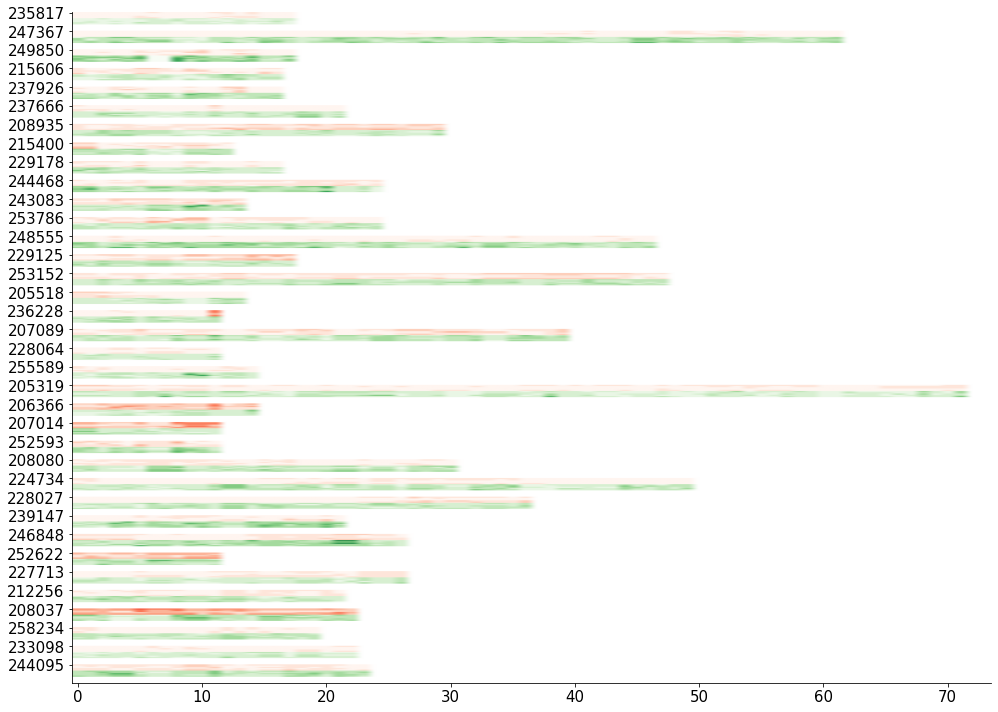

In [39]:
# fps = errs['pid'].values[:36]
tps = df[tp]['pid'].values[:36]
cla_traces, aux_traces, kg = viz.plot_kymographs(df, tps)
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(kg, aspect=.1)
plt.yticks(np.arange(0, 3 * 5 * len(tps), 3 * 5), tps)
plt.show()

# cohort plots

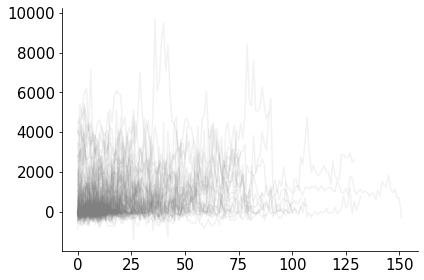

In [24]:
from viz import cr, cp, cg
dd = df.sort_values(by='pid')
for i in range(200):
    plt.plot(dd.iloc[i]['Z'], color='gray', alpha=0.1)
    

# correcting labels

In [ ]:
for idxs, name in zip([fp, fn], ['fp', 'fn']):    
    d = df[idxs]
    errs = viz.viz_biggest_errs(d, None, None, d['y_consec_thresh'],
                                d['preds'] > 0, d['preds'],
                                plot_z=True,
#                                 lifetime_max=100,
                                sort_by_residuals=False,
                                show_track_num=True,
                                num_to_plot=idxs.sum(),
                               )
    plt.savefig(name + '.pdf')
#     viz.savefig(name)

In [57]:
pos_fp = np.array([
    2, 5, 6, 7, 8, 9, 12, 13, 14, 16, 18, 19, 21, 32, 36, 37, 38, 39, 43, 44, 52, 56, 59, 71, 72, 76, 80, 81, 97, 98,
    108, 109, 111, 120, 122, 126, 129, 138, 165, 166, 168, 183, 185, 195, 202, 216, 224, 225, 232, 242, 243, 244, 246,
    247, 261, 268, 279, 288, 294, 308, 324, 326, 327, 340, 342, 345, 346, 365, 378, 380, 396, 401, 425, 440, 447, 485,
    495, 512, 541, 544, 576, 612, 620, 625, 632, 649, 654, 663, 665, 666, 672, 688, 699, 706, 707, 717, 734, 745, 771,
    816, 837, 846, 851, 857, 874, 876, 887, 893, 896, 903, 910, 935, 951, 964, 975, 982, 990, 998, 1000, 1006, 1011,
    1015, 1019, 1021, 1023, 1030, 1031, 1036, 1039, 1045, 1050, 1058, 1061, 1063, 1064, 1070, 1071, 1082, 1086, 1093,
    1095, 1099, 1110, 1113, 1118, 1122, 1126, 1127, 1132, 1143, 1150, 1152, 1155,
])

hotspots_fp = np.array([
    25, 58, 69, 70, 73, 91, 105, 106, 107, 141, 142, 145, 151, 161, 162, 164, 172, 218, 234, 241, 254, 277, 297, 317,
    320, 338, 341, 362, 363, 364, 373, 390, 411, 415, 473, 474, 523, 524, 539, 556, 571, 572, 603, 604, 606, 608, 611,
    613, 621, 624, 638, 639, 640, 648, 676, 679, 686, 692, 702, 703, 715, 743, 744, 762, 774, 775, 777, 781, 786, 790,
    795, 801, 805, 811, 820, 822, 828, 832, 839, 841, 853, 854, 860, 861, 866, 870, 881, 886, 894, 897, 906, 916, 922,
    936, 940, 941, 949, 958, 965, 972, 974, 977, 980, 984, 986, 987, 992, 994, 996, 1001, 1005, 1010, 1013, 1014, 1017,
    1026, 1035, 1037, 1038, 1052, 1053, 1072, 1075, 1078, 1081, 1085, 1087, 1088, 1089, 1092, 1094, 1096, 1097, 1100,
    1101, 1102, 1104, 1107, 1111, 1112, 1114, 1115, 1119, 1120, 1121, 1123, 1124, 1129, 1134, 1145, 1146, 1148, 1154,
])

neg_fn = np.array([
    1, 3, 5, 11, 12, 24, 29, 33, 37, 38, 39, 45, 48, 49, 59, 61, 62, 63, 64, 65, 68, 69, 72, 73, 79, 80, 91, 92, 93, 94,
    99, 101, 104, 105, 106, 107, 108, 113, 123, 124, 127, 131, 132, 136, 138, 140, 141, 147, 149, 153, 154, 156, 160,
    165, 166, 167, 170, 174, 176, 183, 185, 188, 189, 191, 192, 196, 200, 207, 208, 211, 213, 214, 215, 219, 227, 228,
    230, 321, 233, 254, 257, 259, 260, 274, 281, 285, 287, 288, 296, 297, 309, 332, 363, 378, 381, 382, 383, 384, 385,
    393, 394, 402, 405, 413, 427, 478, 482, 483, 509, 512, 513, 514, 520, 524, 527, 544, 548, 549, 552, 556, 557, 559,
    579, 599, 608, 617,
])

hotspots_fn = np.array([
    148, 240, 244, 250, 251, 252, 261, 283, 293, 317, 318, 366, 410, 412, 428, 432, 459, 460, 462, 463, 470, 503, 518,
    519, 565, 568, 589, 590, 600, 605, 614, 619,
])

In [ ]:
d_fp = df[fn]
d = d_fp.iloc[hotspots_fn]
errs = viz.viz_biggest_errs(d, None, None, d['y_consec_thresh'],
                            d['preds'] > 0, d['preds'],
                            plot_z=True,
                            sort_by_residuals=False,
                            num_to_plot=25
                           )

In [62]:
d.pid.values

array([242828, 254428, 257377, 207581, 235660, 205824, 225114, 213307,
       209487, 206981, 239467, 252051, 205115, 206939, 226274, 242758,
       228777, 256040, 255719, 235465, 209012, 222720, 256464, 223698,
       254836, 223231, 254747, 255906, 253835, 254133, 204951, 254969])